# ML-based Detection of Illegal GPS Spoofing by GoJek Drivers using XGBoost Classifier Model

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dsbootcamp10/sample_submission.csv
/kaggle/input/dsbootcamp10/train.csv
/kaggle/input/dsbootcamp10/test.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import missingno as msno
import folium

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

!pip -q install utm
import utm

%config InlineBackend.figure_format = 'retina'

# 1. Read training data

In [3]:
# # Access dataset from repository and unzip
# !wget 'https://github.com/yohanesnuwara/datasets/blob/master/gojek_fake_gps_detection.zip?raw=true'
# !mv '/content/gojek_fake_gps_detection.zip?raw=true' '/content/gojek_fake_gps_detection.zip'
# !unzip '/content/gojek_fake_gps_detection.zip'

In [4]:
train = pd.read_csv('../input/dsbootcamp10/train.csv')

train

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,NaN,23.027,0
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,712.000000,9.577,0
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,712.000000,9.577,0
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,713.000000,8.139,0
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,713.000000,7.029,0
...,...,...,...,...,...,...,...,...,...,...,...
567540,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803198,-6.889018,107.595516,798.799988,21.381,1
567541,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803208,-6.889020,107.595516,798.799988,19.621,1
567542,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803218,-6.889017,107.595526,798.799988,18.012,1
567543,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803228,-6.889017,107.595526,798.799988,18.012,1


**Features description:**

* order_id - an anonymous id unique to a given order number
* service_type - service type, can be GORIDE or GOFOOD
* driver_status - status of the driver PING, can be AVAILABLE, UNAVAILABLE, OTW_PICKUP, OTW_DROPOFF
* hour - hour
* seconds - seconds in linux format
* latitude - GPS latitude
* longitude - GPS longitude
* altitude_in_meters - GPS Altitude
* accuracy_in_meters - GPS Accuracy, the smaller the more accurate

**Target:**

label - label describing whether GPS is true (1) or fake (0)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567545 entries, 0 to 567544
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            567545 non-null  object 
 1   service_type        567545 non-null  object 
 2   driver_status       567545 non-null  object 
 3   date                567545 non-null  object 
 4   hour                567545 non-null  int64  
 5   seconds             567545 non-null  int64  
 6   latitude            567545 non-null  float64
 7   longitude           567545 non-null  float64
 8   altitude_in_meters  413142 non-null  float64
 9   accuracy_in_meters  567545 non-null  float64
 10  label               567545 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 47.6+ MB


There are 154,403 missing values in the altitude column. My first suspection why altitude information can be missing is that fake GPS application may have intermittent or unstable altitude information. So, the missing altitude may become precious predictor (later to be discussed).

In [6]:
train.isnull().sum()

order_id                   0
service_type               0
driver_status              0
date                       0
hour                       0
seconds                    0
latitude                   0
longitude                  0
altitude_in_meters    154403
accuracy_in_meters         0
label                      0
dtype: int64

There are 7,233 zero values in hour column indicating that orders were done at 00:00 midnight. 

In [7]:
# Count zeros. NaN is NOT considered zero
train.isin([0]).astype(int).sum(axis=0)

order_id                   0
service_type               0
driver_status              0
date                       0
hour                    7233
seconds                    0
latitude                   0
longitude                  0
altitude_in_meters         0
accuracy_in_meters         0
label                 159461
dtype: int64

Further, I process the seconds column from Linux format to datetime format. I found out that ALL dates in the Linux seconds column do not match with the date column. I do not have an explanation for this, but I assume this is not important for our prediction task.

In [8]:
from datetime import datetime

# Convert Linux seconds to datetime format
train['linux_date'] = [datetime.utcfromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S') for s in train.seconds.values]

# Convert datetime to Pandas format
train['linux_date'] = pd.to_datetime(train['linux_date'])

# Convert datetime in date column to Pandas format
train['date'] = pd.to_datetime(train['date'])

# Check if date column match with Linux date column
df = train['linux_date'].dt.date==train['date']
print(df.eq(True).all())

False


# 2. Data exploration

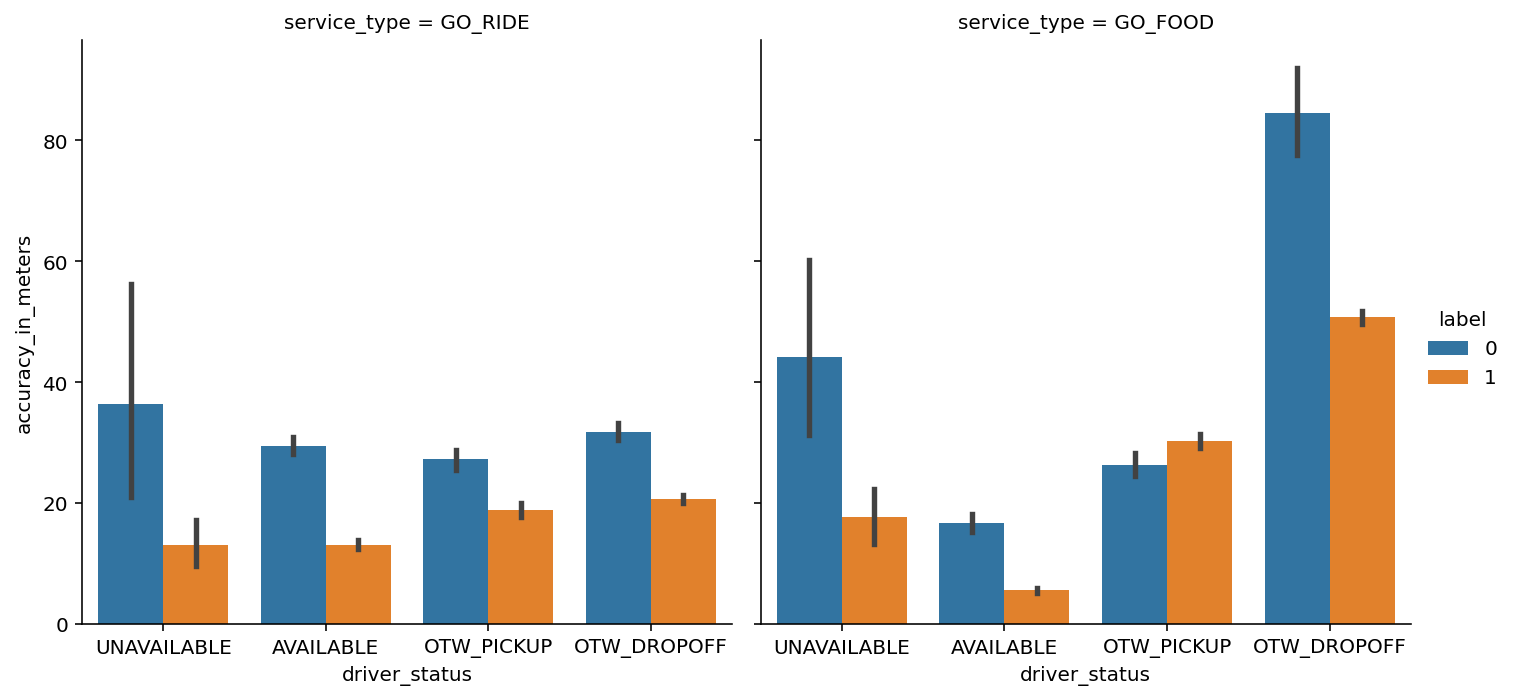

In [9]:
sns.catplot(data=train, x='driver_status', y='accuracy_in_meters', hue='label', col='service_type', kind='bar')

Plotting on Folium

GitHub: [Link](https://github.com/lindseyberlin/Blog_FoliumMaps/blob/master/FoliumMapExamples.ipynb)

Article: [Link](https://dev.to/lberlin/folium-powerful-mapping-tool-for-absolute-beginners-1m5h)

In [10]:
def plot_folium(df, order_id, lat_column, lon_column, location, zoom_start=10):
  # Select subset of dataframe by order ID
  df = df[df.order_id==order_id]

  # Folium plot
  my_map = folium.Map(location=location, zoom_start=zoom_start)  

  # Define different colors for status
  for index, row in df.iterrows():
    if row.driver_status=='UNAVAILABLE':
      color = 'green'
    if row.driver_status=='AVAILABLE':
      color = 'red'
    if row.driver_status=='OTW_PICKUP':
      color = 'black'
    if row.driver_status=='OTW_DROPOFF':
      color = 'blue'

    # Plot coordinates on Folium
    folium.CircleMarker([row[lat_column], row[lon_column]],
                        radius=5, color=color,
                        fill=True).add_to(my_map)

  display(my_map)

In [11]:
# Plot on Folium
plot_folium(train, 'RB193', 'latitude', 'longitude', [-6.920, 107.630], zoom_start=16)

In [12]:
# Plot on Folium
plot_folium(train, 'F842', 'latitude', 'longitude', [-6.920, 107.670], zoom_start=14)

In [13]:
# # !pip -q install contextily
# import contextily as ctx

# f, ax = plt.subplots(figsize=(10,10))
# gdf.to_crs(epsg=3857).plot(ax=ax)
# ctx.add_basemap(ax=ax)

# 3. Feature engineering

First, I differenced latitude, longitude, and seconds columns $(x_t-x_{t-1})$ for each order ID (grouping by order ID then taking difference). 

In [14]:
# Differencing some columns
train['longitude_diff'] = train.groupby('order_id').longitude.diff().fillna(0)
train['latitude_diff'] = train.groupby('order_id').latitude.diff().fillna(0)
train['seconds_diff'] = train.groupby('order_id').seconds.diff().fillna(0)
train['accuracy_diff'] = train.groupby('order_id').accuracy_in_meters.diff().fillna(0)
train['altitude_diff'] = train.groupby('order_id').altitude_in_meters.diff().fillna(0)

train

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label,linux_date,longitude_diff,latitude_diff,seconds_diff,accuracy_diff,altitude_diff
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,NaN,23.027,0,2019-01-30 23:24:27,0.000000e+00,0.000000,0.0,0.000,0.000000
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,712.000000,9.577,0,2019-01-30 23:24:40,-5.150000e-05,-0.000129,13.0,-13.450,0.000000
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,712.000000,9.577,0,2019-01-30 23:24:50,0.000000e+00,0.000000,10.0,0.000,0.000000
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,713.000000,8.139,0,2019-01-30 23:25:00,-1.960000e-05,-0.000009,10.0,-1.438,1.000000
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,713.000000,7.029,0,2019-01-30 23:25:10,2.290000e-05,0.000080,10.0,-1.110,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567540,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803198,-6.889018,107.595516,798.799988,21.381,1,2019-03-17 06:13:18,4.000000e-07,-0.000005,10.0,-1.114,-0.100037
567541,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803208,-6.889020,107.595516,798.799988,19.621,1,2019-03-17 06:13:28,8.000000e-07,-0.000001,10.0,-1.760,0.000000
567542,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803218,-6.889017,107.595526,798.799988,18.012,1,2019-03-17 06:13:38,1.010000e-05,0.000003,10.0,-1.609,0.000000
567543,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803228,-6.889017,107.595526,798.799988,18.012,1,2019-03-17 06:13:48,0.000000e+00,0.000000,10.0,0.000,0.000000


Then, converting the lat lon coordinates to a projected Mercator plane (UTM) coordinates. 

In [15]:
# Convert lat lon to UTM
lat, lon = train.latitude.values, train.longitude.values
x = utm.from_latlon(lat, lon)

train['UTMX'] = x[0]
train['UTMY'] = x[1]

train

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label,linux_date,longitude_diff,latitude_diff,seconds_diff,accuracy_diff,altitude_diff,UTMX,UTMY
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,NaN,23.027,0,2019-01-30 23:24:27,0.000000e+00,0.000000,0.0,0.000,0.000000,790777.283303,9.233968e+06
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,712.000000,9.577,0,2019-01-30 23:24:40,-5.150000e-05,-0.000129,13.0,-13.450,0.000000,790771.509201,9.233954e+06
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,712.000000,9.577,0,2019-01-30 23:24:50,0.000000e+00,0.000000,10.0,0.000,0.000000,790771.509201,9.233954e+06
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,713.000000,8.139,0,2019-01-30 23:25:00,-1.960000e-05,-0.000009,10.0,-1.438,1.000000,790769.336319,9.233953e+06
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,713.000000,7.029,0,2019-01-30 23:25:10,2.290000e-05,0.000080,10.0,-1.110,0.000000,790771.917954,9.233962e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567540,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803198,-6.889018,107.595516,798.799988,21.381,1,2019-03-17 06:13:18,4.000000e-07,-0.000005,10.0,-1.114,-0.100037,786840.489947,9.237740e+06
567541,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803208,-6.889020,107.595516,798.799988,19.621,1,2019-03-17 06:13:28,8.000000e-07,-0.000001,10.0,-1.760,0.000000,786840.577575,9.237740e+06
567542,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803218,-6.889017,107.595526,798.799988,18.012,1,2019-03-17 06:13:38,1.010000e-05,0.000003,10.0,-1.609,0.000000,786841.696077,9.237740e+06
567543,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803228,-6.889017,107.595526,798.799988,18.012,1,2019-03-17 06:13:48,0.000000e+00,0.000000,10.0,0.000,0.000000,786841.696077,9.237740e+06


Then, calculating the step distance between two successive points. For example, at $(t-1)$, the coordinate is at $(x_{t-1}, y_{t-1})$. Then, at $t$, the coordinate is at $(x_t, y_t)$. The step distance is:

$$r=\sqrt{\delta x^2 + \delta y^2}$$

Where $\delta x=x_t-x_{t-1}$ and $\delta y=y_t-y_{t-1}$

In [16]:
# Function to calculate distance between two points
distance = lambda x_dif, y_dif: np.sqrt(x_dif**2 + y_dif**2)

In [17]:
# Differencing UTM coordinates
train['UTMX_diff'] = train.groupby('order_id').UTMX.diff().fillna(0)
train['UTMY_diff'] = train.groupby('order_id').UTMY.diff().fillna(0)

# Calculate step distance
train['distance'] = distance(train.UTMX_diff, train.UTMY_diff)

train['distance']

0          0.000000
1         15.369482
2          0.000000
3          2.380734
4          9.250594
            ...    
567540     0.533000
567541     0.178404
567542     1.153414
567543     0.000000
567544     0.337768
Name: distance, Length: 567545, dtype: float64

## `df_grouped1`

Compressing 567,545 record size by grouping by order ID so that we'll have only 3,500. For each order ID, I calculate the summary stats and other things. 

Grouping by order ID to get the service typeEach order ID has the same service type (GoFood or GoRide) and the same label (0 or 1). 

In [18]:
# Grouping by order ID to get service type and label
df_grouped1 = train.groupby('order_id')[['service_type', 'label']].max()

df_grouped1

,service_type,label
order_id,,
F0,GO_FOOD,1
F1,GO_FOOD,1
F100,GO_FOOD,1
F1000,GO_FOOD,0
F1001,GO_FOOD,1
...,...,...
RB995,GO_RIDE,0
RB996,GO_RIDE,0
RB997,GO_RIDE,0


<AxesSubplot:ylabel='label'>

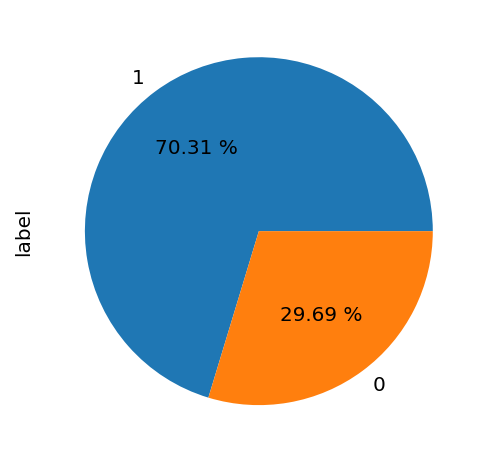

In [19]:
df_grouped1.label.value_counts().plot.pie(autopct='%.2f %%')

For each order ID, I calculate the time difference between two available status and two pickup status (the first and last PING), for this can be a useful predictor. 

In this cartoon here, for example, the user's app shows that the driver is only 100 m from the pick-up spot. Normally it takes 3 minutes to reach the spot. However, the user wait for 10 minutes. This can be an indication that driver uses fake GPS.

<div>
<img src="https://user-images.githubusercontent.com/51282928/144967912-ecc9afb5-1302-4e96-971a-ccdd7d5534ae.png" width="700"/>
</div>

In [20]:
# Calculate time difference between available and otw pickup status

id = list(df_grouped1.index)

for num_id, order_id in enumerate(id):
  # Select dataframe subset w.r.t. order id
  df_id = train[train.order_id==order_id]
  try:
    # Select available status
    avail = df_id[df_id.driver_status=='AVAILABLE']

    # Select pickup status
    pickup = df_id[df_id.driver_status=='OTW_PICKUP']

    # Record the first and last seconds of available and pickup
    t_avail0 = avail.seconds.values[0]
    t_avail1 = avail.seconds.values[1]
    t_pickup0 = pickup.seconds.values[0]
    t_pickup1 = pickup.seconds.values[-1]

    # Calculate time difference of available and pickup last and first seconds
    avail_sec_diff = t_avail1 - t_avail0
    pickup_sec_diff = t_pickup1 - t_pickup0

  except:
    # Set time difference to Null of there is no available/pickup status 
    avail_sec_diff = np.nan
    pickup_sec_diff = np.nan

  # Record time difference to df_grouped1
  df_grouped1.loc[order_id, 'avail_sec_diff'] = avail_sec_diff
  df_grouped1.loc[order_id, 'pickup_sec_diff'] = pickup_sec_diff

  # Logger of every 100 ids
  if num_id%100==0:
    print('Finish ID:', num_id)

Finish ID: 0
Finish ID: 100
Finish ID: 200
Finish ID: 300
Finish ID: 400
Finish ID: 500
Finish ID: 600
Finish ID: 700
Finish ID: 800
Finish ID: 900
Finish ID: 1000
Finish ID: 1100
Finish ID: 1200
Finish ID: 1300
Finish ID: 1400
Finish ID: 1500
Finish ID: 1600
Finish ID: 1700
Finish ID: 1800
Finish ID: 1900
Finish ID: 2000
Finish ID: 2100
Finish ID: 2200
Finish ID: 2300
Finish ID: 2400
Finish ID: 2500
Finish ID: 2600
Finish ID: 2700
Finish ID: 2800
Finish ID: 2900
Finish ID: 3000
Finish ID: 3100
Finish ID: 3200
Finish ID: 3300
Finish ID: 3400


In [21]:
df_grouped1

,service_type,label,avail_sec_diff,pickup_sec_diff
order_id,,,,
F0,GO_FOOD,1,10.0,341.0
F1,GO_FOOD,1,13.0,1484.0
F100,GO_FOOD,1,10.0,2100.0
F1000,GO_FOOD,0,10.0,701.0
F1001,GO_FOOD,1,10.0,160.0
...,...,...,...,...
RB995,GO_RIDE,0,9.0,2010.0
RB996,GO_RIDE,0,10.0,230.0
RB997,GO_RIDE,0,11.0,160.0


## `df_grouped2`

Next, I group by order ID to calculate summary stats (mean, min, max, IQR, and range).

In [22]:
train = train[['order_id', 'service_type', 'driver_status', 'distance', 'hour',
               'accuracy_in_meters', 'accuracy_diff', 'altitude_in_meters', 
               'altitude_diff', 'longitude_diff', 'latitude_diff', 'UTMX_diff', 
               'UTMY_diff', 'seconds_diff', 'label']]

train

,order_id,service_type,driver_status,distance,hour,accuracy_in_meters,accuracy_diff,altitude_in_meters,altitude_diff,longitude_diff,latitude_diff,UTMX_diff,UTMY_diff,seconds_diff,label
0,RB193,GO_RIDE,UNAVAILABLE,0.000000,6,23.027,0.000,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0
1,RB193,GO_RIDE,AVAILABLE,15.369482,6,9.577,-13.450,712.000000,0.000000,-5.150000e-05,-0.000129,-5.774102,-14.243621,13.0,0
2,RB193,GO_RIDE,AVAILABLE,0.000000,6,9.577,0.000,712.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,10.0,0
3,RB193,GO_RIDE,AVAILABLE,2.380734,6,8.139,-1.438,713.000000,1.000000,-1.960000e-05,-0.000009,-2.172882,-0.972870,10.0,0
4,RB193,GO_RIDE,AVAILABLE,9.250594,6,7.029,-1.110,713.000000,0.000000,2.290000e-05,0.000080,2.581635,8.883054,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567540,RB261,GO_RIDE,OTW_DROPOFF,0.533000,13,21.381,-1.114,798.799988,-0.100037,4.000000e-07,-0.000005,0.041347,-0.531394,10.0,1
567541,RB261,GO_RIDE,OTW_DROPOFF,0.178404,13,19.621,-1.760,798.799988,0.000000,8.000000e-07,-0.000001,0.087628,-0.155401,10.0,1
567542,RB261,GO_RIDE,OTW_DROPOFF,1.153414,13,18.012,-1.609,798.799988,0.000000,1.010000e-05,0.000003,1.118502,0.281635,10.0,1
567543,RB261,GO_RIDE,OTW_DROPOFF,0.000000,13,18.012,0.000,798.799988,0.000000,0.000000e+00,0.000000,0.000000,0.000000,10.0,1


In [23]:
# Interquartile and range function
iqr = lambda x: np.percentile(x, 75) - np.percentile(x, 25)
range = lambda x: np.max(x) - np.min(x)

# Drop the last 1 column: label
df_grouped2 = train.iloc[:,:-1]

# Calculate summary statistics
df_grouped2 = df_grouped2.groupby('order_id').aggregate([np.mean, np.min, np.max, np.std, iqr, range])

# Reduce multi-index
df_grouped2.columns = ['_'.join(col).strip() for col in df_grouped2.columns.values]

df_grouped2

,distance_mean,distance_amin,distance_amax,distance_std,distance_<lambda_0>,distance_<lambda_1>,hour_mean,hour_amin,hour_amax,hour_std,...,UTMY_diff_amax,UTMY_diff_std,UTMY_diff_<lambda_0>,UTMY_diff_<lambda_1>,seconds_diff_mean,seconds_diff_amin,seconds_diff_amax,seconds_diff_std,seconds_diff_<lambda_0>,seconds_diff_<lambda_1>
order_id,,,,,,,,,,,,,,,,,,,,,
F0,14.339945,0.0,1118.807094,90.072920,0.000000,1118.807094,10.387387,10,11,0.488254,...,98.200995,89.991405,0.000000,1199.156916,10.054054,0.0,44.0,2.512729,0.00,44.0
F1,14.541167,0.0,837.314263,65.372837,3.865695,837.314263,10.000000,10,10,0.000000,...,821.624825,64.412445,0.477135,915.599324,10.022222,0.0,22.0,1.925877,0.00,22.0
F100,8.864138,0.0,1188.965271,71.406185,0.000000,1188.965271,19.286689,19,20,0.452989,...,1186.097703,70.737485,0.000000,1210.843377,10.058020,0.0,24.0,1.263304,0.00,24.0
F1000,32.465339,0.0,124.793432,37.770346,64.818425,124.793432,7.000000,7,7,0.000000,...,106.238552,32.108486,18.530196,179.882100,11.051282,0.0,46.0,5.699132,0.00,46.0
F1001,32.657449,0.0,1388.360306,131.273117,34.108569,1388.360306,15.000000,15,15,0.000000,...,93.031972,80.128899,1.835792,916.276418,12.779661,0.0,78.0,9.293997,3.00,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB995,24.607497,0.0,361.458205,36.348253,47.629815,361.458205,13.000000,13,13,0.000000,...,68.968981,23.643517,7.073421,155.143974,10.192157,0.0,66.0,3.845226,0.00,66.0
RB996,20.795750,0.0,557.789999,56.777609,5.041282,557.789999,17.149351,17,18,0.357597,...,499.213133,52.222047,0.206988,613.848144,11.383117,0.0,109.0,9.048308,0.00,109.0
RB997,60.767459,0.0,426.849391,79.977001,120.958926,426.849391,7.000000,7,7,0.000000,...,105.436275,71.550556,18.354368,393.668446,12.654545,0.0,31.0,5.652695,6.75,31.0


In [24]:
# Replace column name <lambda_0> to IQR and <lambda_1> to range 
col_groupby2 = df_grouped2.columns
col_groupby2 = [w.replace('<lambda_0>', 'IQR') for w in col_groupby2]
col_groupby2 = [w.replace('<lambda_1>', 'range') for w in col_groupby2]

# Update names of columns
df_grouped2.columns = col_groupby2

df_grouped2

,distance_mean,distance_amin,distance_amax,distance_std,distance_IQR,distance_range,hour_mean,hour_amin,hour_amax,hour_std,...,UTMY_diff_amax,UTMY_diff_std,UTMY_diff_IQR,UTMY_diff_range,seconds_diff_mean,seconds_diff_amin,seconds_diff_amax,seconds_diff_std,seconds_diff_IQR,seconds_diff_range
order_id,,,,,,,,,,,,,,,,,,,,,
F0,14.339945,0.0,1118.807094,90.072920,0.000000,1118.807094,10.387387,10,11,0.488254,...,98.200995,89.991405,0.000000,1199.156916,10.054054,0.0,44.0,2.512729,0.00,44.0
F1,14.541167,0.0,837.314263,65.372837,3.865695,837.314263,10.000000,10,10,0.000000,...,821.624825,64.412445,0.477135,915.599324,10.022222,0.0,22.0,1.925877,0.00,22.0
F100,8.864138,0.0,1188.965271,71.406185,0.000000,1188.965271,19.286689,19,20,0.452989,...,1186.097703,70.737485,0.000000,1210.843377,10.058020,0.0,24.0,1.263304,0.00,24.0
F1000,32.465339,0.0,124.793432,37.770346,64.818425,124.793432,7.000000,7,7,0.000000,...,106.238552,32.108486,18.530196,179.882100,11.051282,0.0,46.0,5.699132,0.00,46.0
F1001,32.657449,0.0,1388.360306,131.273117,34.108569,1388.360306,15.000000,15,15,0.000000,...,93.031972,80.128899,1.835792,916.276418,12.779661,0.0,78.0,9.293997,3.00,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB995,24.607497,0.0,361.458205,36.348253,47.629815,361.458205,13.000000,13,13,0.000000,...,68.968981,23.643517,7.073421,155.143974,10.192157,0.0,66.0,3.845226,0.00,66.0
RB996,20.795750,0.0,557.789999,56.777609,5.041282,557.789999,17.149351,17,18,0.357597,...,499.213133,52.222047,0.206988,613.848144,11.383117,0.0,109.0,9.048308,0.00,109.0
RB997,60.767459,0.0,426.849391,79.977001,120.958926,426.849391,7.000000,7,7,0.000000,...,105.436275,71.550556,18.354368,393.668446,12.654545,0.0,31.0,5.652695,6.75,31.0


## `df_grouped3`

Make dummies from driver status, then for each order ID groups, I count the PINGS of each status.

In [25]:
# Get dummies of driver status
train = pd.get_dummies(train, columns=['driver_status'])

train

,order_id,service_type,distance,hour,accuracy_in_meters,accuracy_diff,altitude_in_meters,altitude_diff,longitude_diff,latitude_diff,UTMX_diff,UTMY_diff,seconds_diff,label,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE
0,RB193,GO_RIDE,0.000000,6,23.027,0.000,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0,0,0,0,1
1,RB193,GO_RIDE,15.369482,6,9.577,-13.450,712.000000,0.000000,-5.150000e-05,-0.000129,-5.774102,-14.243621,13.0,0,1,0,0,0
2,RB193,GO_RIDE,0.000000,6,9.577,0.000,712.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,10.0,0,1,0,0,0
3,RB193,GO_RIDE,2.380734,6,8.139,-1.438,713.000000,1.000000,-1.960000e-05,-0.000009,-2.172882,-0.972870,10.0,0,1,0,0,0
4,RB193,GO_RIDE,9.250594,6,7.029,-1.110,713.000000,0.000000,2.290000e-05,0.000080,2.581635,8.883054,10.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567540,RB261,GO_RIDE,0.533000,13,21.381,-1.114,798.799988,-0.100037,4.000000e-07,-0.000005,0.041347,-0.531394,10.0,1,0,1,0,0
567541,RB261,GO_RIDE,0.178404,13,19.621,-1.760,798.799988,0.000000,8.000000e-07,-0.000001,0.087628,-0.155401,10.0,1,0,1,0,0
567542,RB261,GO_RIDE,1.153414,13,18.012,-1.609,798.799988,0.000000,1.010000e-05,0.000003,1.118502,0.281635,10.0,1,0,1,0,0
567543,RB261,GO_RIDE,0.000000,13,18.012,0.000,798.799988,0.000000,0.000000e+00,0.000000,0.000000,0.000000,10.0,1,0,1,0,0


In [26]:
# Count number of PING by driver status
df_grouped3 = train.groupby('order_id')[['driver_status_AVAILABLE', 'driver_status_OTW_DROPOFF',
                                         'driver_status_OTW_PICKUP','driver_status_UNAVAILABLE']].sum()

df_grouped3

,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE
order_id,,,,
F0,114.0,71.0,35.0,2.0
F1,35.0,116.0,27.0,2.0
F100,5.0,75.0,211.0,2.0
F1000,53.0,5.0,59.0,0.0
F1001,37.0,64.0,16.0,1.0
...,...,...,...,...
RB995,75.0,102.0,78.0,0.0
RB996,120.0,10.0,24.0,0.0
RB997,23.0,70.0,17.0,0.0


## `df_grouped4`

As mentioned before, altitude contains many missing values. I presumed that it is possible that a fake GPS give unstable altitude, thus more missing altitudes.

Here, I counted the missing altitudes of each order ID groups, and use as new feature.

In [27]:
df_grouped4 = train[['order_id', 'altitude_in_meters']]

# Check for each row if altitude is Null
df_grouped4['altitude_isnan'] = df_grouped4.altitude_in_meters.isnull()

df_grouped4 = df_grouped4.groupby('order_id')[['altitude_isnan']].sum()

df_grouped4

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,altitude_isnan
order_id,
F0,12
F1,42
F100,0
F1000,0
F1001,57
...,...
RB995,0
RB996,0
RB997,8


## Combined all new features

**After feature engineering, the new size of dataset is (3500, 74) where 3500=number of order ID and 74=number of new features.**

In [28]:
# Merge all grouped dataframe
df = pd.concat((df_grouped1, df_grouped2, df_grouped3, df_grouped4), axis=1)

# Encode service_type
service_label = {'service_type': {'GO_FOOD': 0, 'GO_RIDE': 1}}
df = df.replace(service_label)

df

,service_type,label,avail_sec_diff,pickup_sec_diff,distance_mean,distance_amin,distance_amax,distance_std,distance_IQR,distance_range,...,seconds_diff_amin,seconds_diff_amax,seconds_diff_std,seconds_diff_IQR,seconds_diff_range,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,altitude_isnan
order_id,,,,,,,,,,,,,,,,,,,,,
F0,0,1,10.0,341.0,14.339945,0.0,1118.807094,90.072920,0.000000,1118.807094,...,0.0,44.0,2.512729,0.00,44.0,114.0,71.0,35.0,2.0,12
F1,0,1,13.0,1484.0,14.541167,0.0,837.314263,65.372837,3.865695,837.314263,...,0.0,22.0,1.925877,0.00,22.0,35.0,116.0,27.0,2.0,42
F100,0,1,10.0,2100.0,8.864138,0.0,1188.965271,71.406185,0.000000,1188.965271,...,0.0,24.0,1.263304,0.00,24.0,5.0,75.0,211.0,2.0,0
F1000,0,0,10.0,701.0,32.465339,0.0,124.793432,37.770346,64.818425,124.793432,...,0.0,46.0,5.699132,0.00,46.0,53.0,5.0,59.0,0.0,0
F1001,0,1,10.0,160.0,32.657449,0.0,1388.360306,131.273117,34.108569,1388.360306,...,0.0,78.0,9.293997,3.00,78.0,37.0,64.0,16.0,1.0,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB995,1,0,9.0,2010.0,24.607497,0.0,361.458205,36.348253,47.629815,361.458205,...,0.0,66.0,3.845226,0.00,66.0,75.0,102.0,78.0,0.0,0
RB996,1,0,10.0,230.0,20.795750,0.0,557.789999,56.777609,5.041282,557.789999,...,0.0,109.0,9.048308,0.00,109.0,120.0,10.0,24.0,0.0,0
RB997,1,0,11.0,160.0,60.767459,0.0,426.849391,79.977001,120.958926,426.849391,...,0.0,31.0,5.652695,6.75,31.0,23.0,70.0,17.0,0.0,8


## Calculate correlation with target

From the bar plot, we get top 10 features with highest correlation with target, as follows:

distance IQR, altitude difference IQR, UTMX UTMY difference IQR, latitude longitude difference IQR, accuracy difference IQR, min of distance, and missing altitude counts 

<AxesSubplot:>

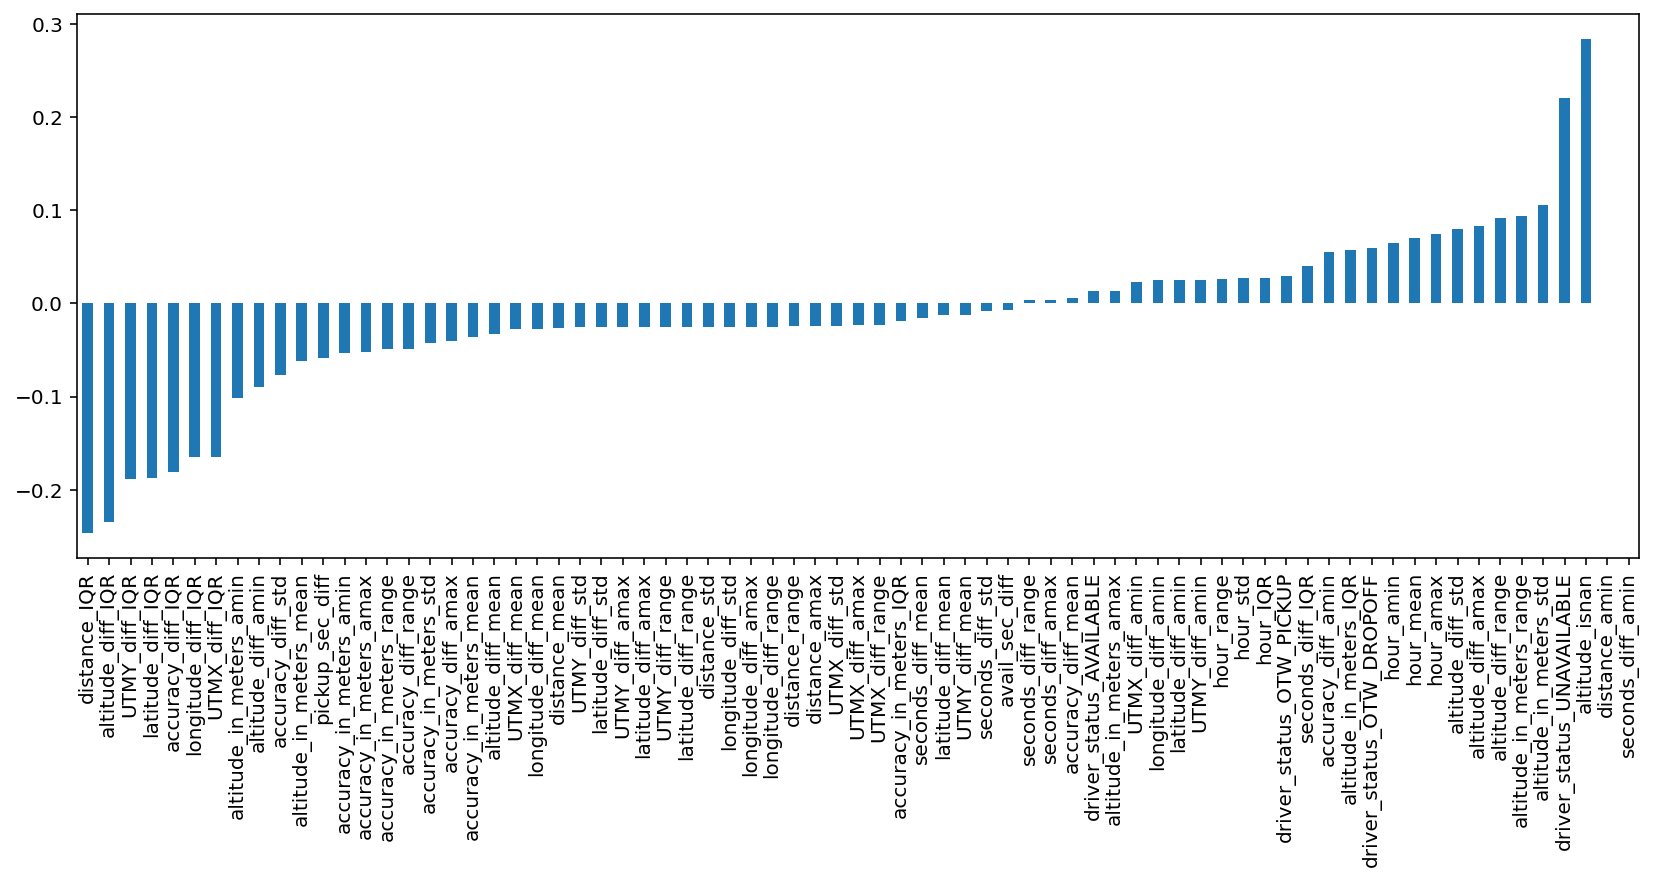

In [29]:
# Correlation bar plot
df.corr()['label'][2:].sort_values(ascending=True).plot.bar(figsize=(14,5))

In [30]:
# plt.scatter(train.longitude, train.latitude, c=train.label, s=5)
# plt.xlim(107.4,107.9)
# plt.ylim(-7.1,-6.7)

# Machine learning - training and evaluation

An XGBoost classifier model is built to classify if the GPS is true (1) or fake (0).

In [31]:
# Feature and target
X = df.drop(columns=['label'])
y = df.label

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline
pipe = make_pipeline(StandardScaler(), XGBClassifier())

# Define multiple scoring metrics
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Stratified K-Fold
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation.Ignore the warning
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The CV scores show all mean precision, recall, and F1-score of 79%. 

In [32]:
# Print scoring results from dictionary
for metric_name, metric_value in cv_scores.items():
    mean = np.mean(metric_value)
    print(f'{metric_name}: {np.round(metric_value, 4)}, Mean: {np.round(mean, 4)}')

fit_time: [1.787  1.6662 1.667  1.5244 1.6699], Mean: 1.6629
score_time: [0.013  0.0125 0.0126 0.0133 0.0127], Mean: 0.0128
test_acc: [0.8408 0.8367 0.8245 0.8245 0.8143], Mean: 0.8282
test_prec_macro: [0.8108 0.8061 0.7939 0.7914 0.7788], Mean: 0.7962
test_rec_macro: [0.8058 0.8037 0.7794 0.7891 0.7799], Mean: 0.7916
test_f1_macro: [0.8082 0.8049 0.7859 0.7902 0.7793], Mean: 0.7937


In [33]:
# Fit pipeline to train set
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
# Save pipeline into pickle
import joblib
joblib.dump(pipe, './gojek_xgboost.pkl')

['./gojek_xgboost.pkl']

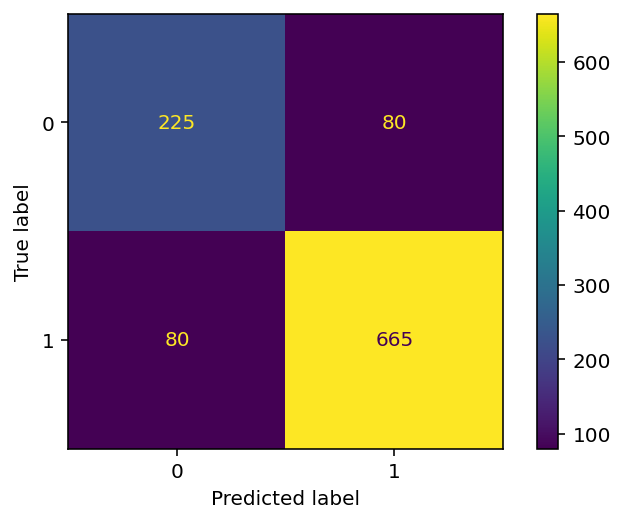

In [35]:
# Confusion matrix of test set
plot_confusion_matrix(pipe, X_test, y_test, values_format='.5g') 
plt.show()

In [36]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       305
           1       0.89      0.89      0.89       745

    accuracy                           0.85      1050
   macro avg       0.82      0.82      0.82      1050
weighted avg       0.85      0.85      0.85      1050



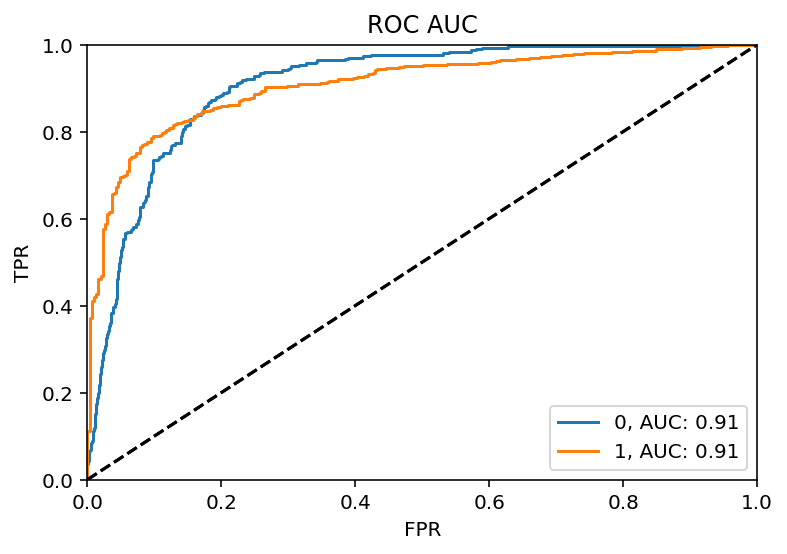

In [37]:
# Generate class membership probabilities
y_pred_probs = pipe.predict_proba(X_test)

classes = [0,1]

# For each class
for i, clas in enumerate(classes):
  # Calculate False Positive Rate, True Negative Rate
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,i], 
                                   pos_label = clas) 
  
  # Calculate AUC
  auroc = auc(fpr, tpr)
  
  # Plot ROC AUC curve for each class
  plt.plot(fpr, tpr, label=f'{clas}, AUC: {auroc:.2f}')
  plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC AUC')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.xlim(0,1); plt.ylim(0,1)
plt.legend()
plt.show()

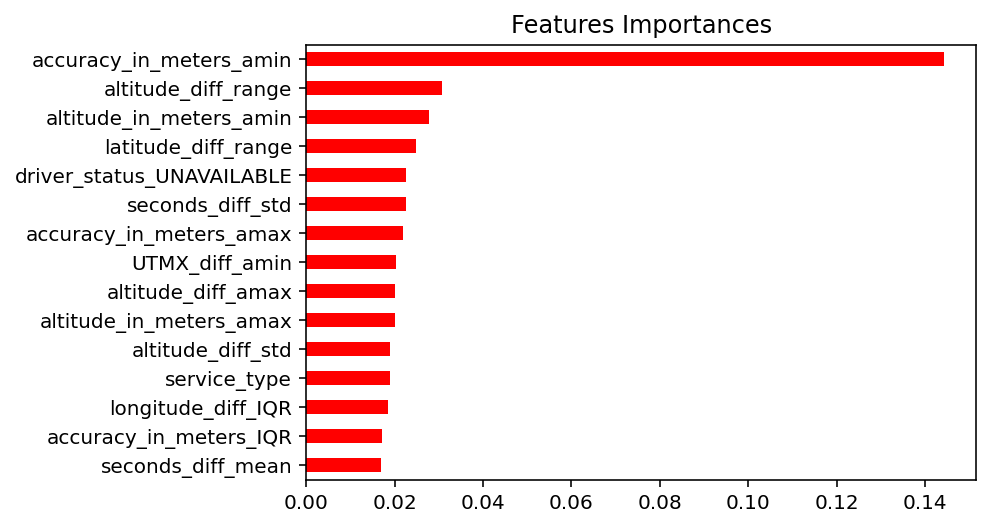

In [38]:
# Create a pd.Series of features importances
fimp = pipe.steps[1][1].feature_importances_
importances = pd.Series(data=fimp,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()[-15:]

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='red')
plt.title('Features Importances')
plt.show()

# Predict on test set

Creating a function to transform the test data by grouping by each order ID and engineer 74 new features.

In [39]:
def gojek_data_transform(df):
  # Differencing some columns
  df['longitude_diff'] = df.groupby('order_id').longitude.diff().fillna(0)
  df['latitude_diff'] = df.groupby('order_id').latitude.diff().fillna(0)
  df['seconds_diff'] = df.groupby('order_id').seconds.diff().fillna(0)
  df['accuracy_diff'] = df.groupby('order_id').accuracy_in_meters.diff().fillna(0)
  df['altitude_diff'] = df.groupby('order_id').altitude_in_meters.diff().fillna(0)

  # Convert lat lon to UTM
  lat, lon = df.latitude.values, df.longitude.values
  x = utm.from_latlon(lat, lon)

  df['UTMX'] = x[0]
  df['UTMY'] = x[1]

  # Function to calculate distance between two points
  distance = lambda x_dif, y_dif: np.sqrt(x_dif**2 + y_dif**2)

  # Differencing UTM coordinates
  df['UTMX_diff'] = df.groupby('order_id').UTMX.diff().fillna(0)
  df['UTMY_diff'] = df.groupby('order_id').UTMY.diff().fillna(0)

  # Calculate step distance
  df['distance'] = distance(df.UTMX_diff, df.UTMY_diff)

  # Grouping by order ID to get service type and label
  df_grouped1 = df.groupby('order_id')[['service_type']].max()

  # Calculate time difference between available and otw pickup status
  id = list(df_grouped1.index)

  for num_id, order_id in enumerate(id):
    # Select dataframe subset w.r.t. order id
    df_id = df[df.order_id==order_id]
    try:
      # Select available status
      avail = df_id[df_id.driver_status=='AVAILABLE']

      # Select pickup status
      pickup = df_id[df_id.driver_status=='OTW_PICKUP']

      # Record the first and last seconds of available and pickup
      t_avail0 = avail.seconds.values[0]
      t_avail1 = avail.seconds.values[1]
      t_pickup0 = pickup.seconds.values[0]
      t_pickup1 = pickup.seconds.values[-1]

      # Calculate time difference of available and pickup last and first seconds
      avail_sec_diff = t_avail1 - t_avail0
      pickup_sec_diff = t_pickup1 - t_pickup0

    except:
      # Set time difference to Null of there is no available/pickup status 
      avail_sec_diff = np.nan
      pickup_sec_diff = np.nan

    # Record time difference to df_grouped1
    df_grouped1.loc[order_id, 'avail_sec_diff'] = avail_sec_diff
    df_grouped1.loc[order_id, 'pickup_sec_diff'] = pickup_sec_diff

  df = df[['order_id', 'service_type', 'driver_status', 'distance', 'hour',
            'accuracy_in_meters', 'accuracy_diff', 'altitude_in_meters', 
            'altitude_diff', 'longitude_diff', 'latitude_diff', 'UTMX_diff', 
            'UTMY_diff', 'seconds_diff']]

  # Interquartile and range function
  iqr = lambda x: np.percentile(x, 75) - np.percentile(x, 25)
  range = lambda x: np.max(x) - np.min(x)

  # Calculate summary statistics
  df_grouped2 = df.groupby('order_id').aggregate([np.mean, np.min, np.max, np.std, iqr, range])

  # Reduce multi-index
  df_grouped2.columns = ['_'.join(col).strip() for col in df_grouped2.columns.values]

  # Replace column name <lambda_0> to IQR and <lambda_1> to range 
  col_groupby2 = df_grouped2.columns
  col_groupby2 = [w.replace('<lambda_0>', 'IQR') for w in col_groupby2]
  col_groupby2 = [w.replace('<lambda_1>', 'range') for w in col_groupby2]

  # Update names of columns
  df_grouped2.columns = col_groupby2

  # Get dummies of driver status
  df = pd.get_dummies(df, columns=['driver_status'])

  # Count number of PING by driver status
  df_grouped3 = df.groupby('order_id')[['driver_status_AVAILABLE', 'driver_status_OTW_DROPOFF',
                                          'driver_status_OTW_PICKUP','driver_status_UNAVAILABLE']].sum()
  df_grouped4 = df[['order_id', 'altitude_in_meters']]

  # Check for each row if altitude is Null
  df_grouped4['altitude_isnan'] = df_grouped4.altitude_in_meters.isnull()

  df_grouped4 = df_grouped4.groupby('order_id')[['altitude_isnan']].sum()

  # Merge all grouped dataframe
  df = pd.concat((df_grouped1, df_grouped2, df_grouped3, df_grouped4), axis=1)

  # Encode service_type
  service_label = {'service_type': {'GO_FOOD': 0, 'GO_RIDE': 1}}
  df = df.replace(service_label)  

  return df

In [40]:
# Read test set
test = pd.read_csv('../input/dsbootcamp10/test.csv')

test

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters
0,F1770,GO_FOOD,AVAILABLE,2018-02-05,18,1548932409,-6.923841,107.700414,NaN,5.000
1,F1770,GO_FOOD,AVAILABLE,2018-02-05,18,1548932419,-6.923841,107.700414,NaN,5.000
2,F1770,GO_FOOD,AVAILABLE,2018-02-05,18,1548932429,-6.923841,107.700414,NaN,5.000
3,F1770,GO_FOOD,AVAILABLE,2018-02-05,18,1548932439,-6.923841,107.700414,NaN,5.000
4,F1770,GO_FOOD,AVAILABLE,2018-02-05,18,1548932449,-6.923841,107.700414,NaN,5.000
...,...,...,...,...,...,...,...,...,...,...
81329,F1345,GO_FOOD,OTW_DROPOFF,2018-03-22,19,1552824829,-6.918310,107.620607,721.7,10.300
81330,F1345,GO_FOOD,OTW_DROPOFF,2018-03-22,19,1552824839,-6.918215,107.620626,722.5,7.204
81331,F1345,GO_FOOD,OTW_DROPOFF,2018-03-22,19,1552824849,-6.918156,107.620666,722.4,6.396
81332,F1345,GO_FOOD,OTW_DROPOFF,2018-03-22,19,1552824859,-6.918137,107.620686,722.5,6.198


After transformation, the size of test set is (500, 74) where 500=number of order ID and 74=number of new features.

In [41]:
# Transform test set to produce 74 features
test_ready = gojek_data_transform(test)

test_ready

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,service_type,avail_sec_diff,pickup_sec_diff,distance_mean,distance_amin,distance_amax,distance_std,distance_IQR,distance_range,hour_mean,...,seconds_diff_amin,seconds_diff_amax,seconds_diff_std,seconds_diff_IQR,seconds_diff_range,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,altitude_isnan
order_id,,,,,,,,,,,,,,,,,,,,,
F10,0,10.0,2791.0,35.549151,0.0,228.191557,47.605736,54.342220,228.191557,15.181009,...,0.0,33.0,3.694563,1.0,33.0,27.0,215.0,95.0,0.0,2
F1008,0,2660.0,800.0,28.147665,0.0,178.404411,38.304803,41.566201,178.404411,19.593156,...,0.0,72.0,4.172996,0.0,72.0,2.0,183.0,78.0,0.0,2
F1011,0,10.0,488.0,64.992840,0.0,977.945641,181.036109,37.506548,977.945641,16.726496,...,0.0,40.0,4.203086,0.0,40.0,73.0,0.0,42.0,2.0,0
F1022,0,10.0,1537.0,4.491452,0.0,112.730978,11.952422,1.397625,112.730978,14.380623,...,0.0,98.0,6.734274,0.0,98.0,59.0,99.0,131.0,0.0,192
F103,0,50.0,1141.0,35.667358,0.0,1373.749748,170.205968,0.000000,1373.749748,14.011494,...,0.0,51.0,9.363605,7.0,51.0,17.0,25.0,41.0,4.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB926,1,10.0,160.0,39.535856,0.0,128.317020,39.074195,55.439686,128.317020,18.000000,...,0.0,15.0,1.842222,0.0,15.0,13.0,24.0,17.0,0.0,0
RB928,1,24.0,809.0,43.608011,0.0,209.925600,50.902515,72.819711,209.925600,14.253333,...,0.0,24.0,1.688841,0.0,24.0,49.0,137.0,39.0,0.0,2
RB955,1,9.0,790.0,19.672875,0.0,202.097466,33.704002,32.379091,202.097466,6.000000,...,0.0,650.0,63.700887,0.0,650.0,21.0,0.0,80.0,0.0,0


In [42]:
# Predict on test set
y_pred = pipe.predict(test_ready)

# Print the first 20 predictions
print(y_pred[:20])

[0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0]


In [43]:
# Make submission dataframe
submission = test_ready.reset_index().iloc[:,:1]
submission['label'] = y_pred

submission

,order_id,label
0,F10,0
1,F1008,1
2,F1011,0
3,F1022,1
4,F103,1
...,...,...
495,RB926,0
496,RB928,0
497,RB955,0
498,RB976,1


In [44]:
# Submission to csv
submission.to_csv('./GoJek_submission.csv', index=False)